# Building Recurrent Models for Splicing Prediction with Synthetic and Genomic Data, Part 1: Basic Models

I want to try to train models on synthetic data that can also work on genomic data. In other words, we'll try to predict the PSI for mutations in genomic sequences based on a neural network model trained on synthetic data.

How would that work? Well, first of all we need a model that works for variable-length sequences. This basically requires some kind of recurrent network.

Ideas:
- convolutional layer at the bottom, with a recurrent layer on top that has only one final output (or multiple recurrent units that all get softmaxed together) (call it a "convolutional accumulator network")
- recurrent layer on bottom, possibly one or more recurrent layers above, one final output

The idea is that we will run the network on the alternative exon to predict its PSI.

In [1]:
from keras.models import Sequential
from keras.layers import Convolution1D, LSTM, GRU, Dense
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

Using Theano backend.


In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src/'))

In [3]:
import lasagne_test

In [4]:
import numpy as np

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle

In [44]:
from sklearn.metrics import r2_score

## Step 1: Loading Data

In [13]:
X_train, X_test, Y_train, Y_test = lasagne_test.load_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [14]:
print X1_train.shape

(212035, 25, 4)


In [9]:
print Y2_train.shape

(212035, 1)


## Step 2: Convolutional-Recurrent Model

Here we'll try to train a model solely on the alternative exon, that solely predicts the times splice donor 2 is used.

In [6]:
num_filters = 64
filter_length = 6

model = Sequential()
model.add(Convolution1D(num_filters, filter_length, activation='relu', input_dim=4))
model.add(LSTM(output_dim=64))
model.add(Dense(output_dim=1, activation='sigmoid'))

In [7]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer='adam')

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(X1_train, Y2_train,
          nb_epoch=10,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/100
212035/212035 [==============================] - 196s - loss: 0.5199 - acc: 1.0000 - val_loss: 0.5247 - val_acc: 1.0000
Epoch 2/100
212035/212035 [==============================] - 192s - loss: 0.5139 - acc: 1.0000 - val_loss: 0.5127 - val_acc: 1.0000
Epoch 3/100
212035/212035 [==============================] - 200s - loss: 0.5107 - acc: 1.0000 - val_loss: 0.5096 - val_acc: 1.0000
Epoch 4/100
212035/212035 [==============================] - 198s - loss: 0.5085 - acc: 1.0000 - val_loss: 0.5082 - val_acc: 1.0000
Epoch 5/100
212035/212035 [==============================] - 211s - loss: 0.5068 - acc: 1.0000 - val_loss: 0.5075 - val_acc: 1.0000
Epoch 6/100
212035/212035 [==============================] - 185s - loss: 0.5057 - acc: 1.0000 - val_loss: 0.5050 - val_acc: 1.0000
Epoch 7/100
212035/212035 [==============================] - 181s - loss: 0.5046 - acc: 1.0000 - val_loss: 0.5071 - val_acc: 1.0000
Epoch 8/100
 35500/212035

KeyboardInterrupt: 

In [42]:
model_json = model.to_json()

In [43]:
model.save_weights('../data/convolutional-recurrent.h5', overwrite=True)

In [44]:
with open('../data/convolutional-recurrent-model.json', 'w') as f:
    f.write(model_json)

In [45]:
predictions = model.predict(X1_test)

In [46]:
predictions

array([[ 0.76264477],
       [ 0.81624645],
       [ 0.7444979 ],
       ..., 
       [ 0.75111055],
       [ 0.12684089],
       [ 0.61260176]])

In [49]:
r2_score(Y2_test, predictions)

0.62427336993347304

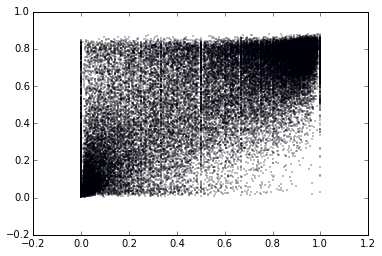

In [50]:
plt.scatter(Y2_test, predictions, s=0.1)

## Step 3: Testing on Genomic Data

Data is located at ../../alternative_splicing_snp_prediction/data/alt_5_gtex.db, ../../alternative_splicing_snp_prediction/data/alt_exons.db, ../../alternative_splicing_snp_prediction/data/skipped_exon_gtex.db.

Code to load this data is...

In [9]:
import sqlite3

def lookup_A5(chrom, pos):
    """
    Given a position, finds all events that contain an alternative exon that includes the given position.
    Returns a list of events - list of tuples 
    (event_id, gene_id, alt_exon_start, alt_exon_end, chrom, strand, baseline_psi)
    """
    conn = sqlite3.connect('../../alternative_splicing_snp_prediction/data/alt_5_gtex.db')
    cur = conn.cursor()
    # leaving a
    cur.execute("SELECT * FROM alt_5 WHERE chrom=? AND alt_exon_start < ? AND alt_exon_end > ?;",
                (chrom, pos+3, pos-6))
    results = cur.fetchall()
    return results

def lookup_SE(chrom, pos):
    """
    Given a position, finds all events that contain an alternative exon that includes the given position.
    Returns a list of events - list of tuples 
    (event_id, gene_id, alt_exon_start, alt_exon_end, chrom, strand, baseline_psi)
    """
    conn = sqlite3.connect('./../alternative_splicing_snp_prediction/data/skipped_exon_gtex.db')
    cur = conn.cursor()
    # leaving a
    cur.execute("SELECT * FROM skipped_exon WHERE chrom=? AND alt_exon_start < ? AND alt_exon_end > ?;",
                (chrom, pos+3, pos-6))
    results = cur.fetchall()
    return results

def lookup_sequence_db(event_id):
    """
    Given an event id (alt_5 or skipped exon), finds the alternative exon
    corresponding to that event.
    """
    conn = sqlite3.connect('../../alternative_splicing_snp_prediction/data/alt_exons.db')
    cur = conn.cursor()
    cur.execute('SELECT seq FROM exons WHERE event_id=?', (event_id,))
    results = cur.fetchone()
    return results[0]

In [10]:
def extract_alt5_data():
    conn = sqlite3.connect('../../alternative_splicing_snp_prediction/data/alt_5_gtex.db')
    cur = conn.cursor()
    cur.execute('SELECT * FROM alt_5;')
    data_out = []
    for e in cur.fetchall():
        event_id = e[0]
        gene = e[1]
        start = e[2]
        end = e[3]
        seq = lookup_sequence_db(event_id)
        wt_psi = e[6]
        data_out.append((event_id, seq, wt_psi))
    return data_out

In [58]:
#data = extract_alt5_data()

In [61]:
with open('../data/genomic_alt_5_gtex.pkl', 'w') as f:
    cPickle.dump(data, f)

In [62]:
genomic_exons = [c[1] for c in data]

In [79]:
genomic_exons_encoded = [lasagne_test.seq_to_array(s) for s in genomic_exons]

In [80]:
#genomic_exons_encoded = map(lambda x: np.rollaxis(x, 1), genomic_exons_encoded)
genomic_exons_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), genomic_exons_encoded)

In [81]:
print genomic_exons_encoded[0].shape

(1, 426, 4)


In [82]:
model.predict(genomic_exons_encoded[0])

array([[ 0.37398115]])

In [84]:
predictions = [model.predict(genomic_exons_encoded[i]) for i in range(len(genomic_exons_encoded))]

In [85]:
actual = [c[2] for c in data]

In [89]:
p2 = [p[0][0] for p in predictions]

In [137]:
new_actual = []
new_pred = []
new_g = []
for a, p, g in zip(actual, p2, genomic_exons_encoded):
    if a!=None and a!=0 and a!=-1:
        new_actual.append(a)
        new_pred.append(1-p)
        new_g.append(g)

In [111]:
r2_score(new_actual, new_pred)

-0.73359135432120115

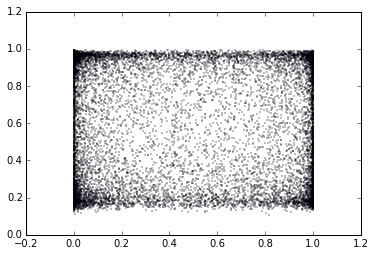

In [112]:
plt.scatter(new_actual, new_pred, s=0.1)
plt.show()

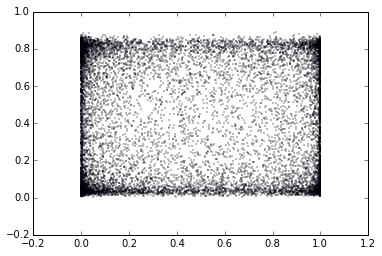

In [108]:
plt.scatter(new_actual, [1-p for p in new_pred], s=0.1)
plt.show()

## Step 4: Training on genomic data

Since this fails so horribly why don't we train on genomic data?

In [12]:
data = cPickle.load(open('../data/genomic_alt_5_gtex.pkl'))

In [20]:
genomic_exons = [c[1] for c in data]
genomic_exons_encoded = [lasagne_test.seq_to_array(s) for s in genomic_exons]
actual = [c[2] for c in data]
new_actual = []
new_g = []
for a, g in zip(actual, genomic_exons_encoded):
    if a!=None and a!=0 and a!=-1 and len(g)<400:
        new_actual.append(a)
        new_g.append(g)

In [21]:
max_len = max([len(x) for x in new_g])
max_len

399

In [22]:
new_g[0].shape

(194, 4)

In [34]:
new_g2 = map(lambda x: np.rollaxis(sequence.pad_sequences(np.rollaxis(x, 1), max_len), 1), new_g)

In [35]:
new_g2 = np.dstack(new_g2)

In [36]:
new_g2.shape

(399, 4, 11850)

In [37]:
new_g2 = np.rollaxis(new_g2, 2)

In [38]:
new_g2.shape

(11850, 399, 4)

In [39]:
from sklearn.cross_validation import train_test_split

G_train, G_test, P_train, P_test = train_test_split(new_g2, new_actual, test_size=0.2, random_state=0)

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(G_train, P_train,
          nb_epoch=10,
          batch_size=500,
          show_accuracy=True,
          validation_data=(G_test, P_test),
          callbacks=[early_stopping])

Train on 9480 samples, validate on 2370 samples
Epoch 1/10
9480/9480 [==============================] - 178s - loss: 0.6899 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 1.0000
Epoch 2/10
9480/9480 [==============================] - 170s - loss: 0.6898 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 1.0000
Epoch 3/10
9480/9480 [==============================] - 177s - loss: 0.6897 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 1.0000
Epoch 4/10
9480/9480 [==============================] - 177s - loss: 0.6896 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 1.0000
Epoch 5/10
9480/9480 [==============================] - 183s - loss: 0.6895 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 1.0000
Epoch 6/10
9480/9480 [==============================] - 194s - loss: 0.6894 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 1.0000
Epoch 7/10
9480/9480 [==============================] - 168s - loss: 0.6892 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 1.0000
Epoch 8/10
9480/9480 [==============================] - 157s - 

In [147]:
len(G_train)

6649

In [151]:
new_actual2

array([[ 0.08627286],
       [ 0.92350158],
       [ 0.48860904],
       ..., 
       [ 0.88680802],
       [ 0.89774962],
       [ 0.00136388]])

In [155]:
len(G_train[0][0])

426

In [47]:
predictions = model.predict(G_test)

In [48]:
r2_score(P_test, predictions)

0.0033888933173659153

This is a bad r2... but at least it's positive!!!!!

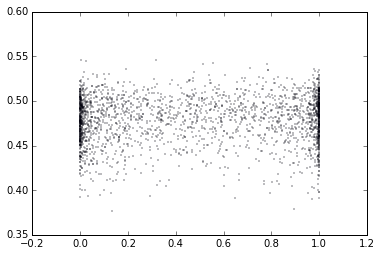

In [51]:
plt.scatter(P_test, predictions, s=0.1)